# Essais de réseaux de neurones pour le projet

In [118]:
import gzip
import time
import numpy
import numpy as np
import shutil

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
import torchvision.transforms as T
import matplotlib
matplotlib.rcParams['figure.figsize'] = (9.0, 7.0)
from matplotlib import pyplot as plt
import os
import cmath
j = cmath.sqrt(-1)

#### Créer un Pytorch dataset et un dataloader

In [119]:
lambda_ = np.linspace(1500e-9,1600e-9,1001)
class CDCDataset(Dataset):

    def __init__(self, path, set_type="train"):
        super().__init__()
        # garde les paramètres en mémoire
        self.path = path
        # charger les données
        self.tx1 = torch.load('tX1.pt')
        self.tx2 = torch.load('tX2.pt')
        self.ty = torch.load('ty.pt')

        y = torch.Tensor(self.tx1.shape[0],int(self.tx1.shape[1]/2))
        y_reshape = torch.reshape(self.tx1,(self.tx1.shape[0],2,int(self.tx1.shape[1]/2)))
        y[:,:] = y_reshape[:,1,:]

        x = torch.Tensor(self.tx2.shape[0],3,int(self.tx2.shape[1]/2-1))
        x_reshape = torch.reshape(self.tx2,(len(self.ty),2,101))
        x[:,0,:] = ((x_reshape[:,0,:-1])/50000)
        x[:,1,:] = (((x_reshape[:,1,:-1])-torch.min(x_reshape[:,1,:-1]))/(torch.max(x_reshape[:,1,:-1])-torch.min(x_reshape[:,1,:-1])))
        x[:,2,:] = (self.ty[:,1]/torch.max(self.ty[:,1])).unsqueeze(-1).expand(len(self.ty),100)
        self.X = []
        self.Y = []
        self.data =[]
        for i in range(len(self.ty)):   
            self.X.append(x[i])# D.append(X2[i].unsqueeze(0))
            self.Y.append(np.abs(y[i,:]))#     U.append(10*np.log10(np.abs(Y2[i,:])**2))      
            self.data .append([x[i],y[i,:]]) #Data.append([X2[i].unsqueeze(0),Y2[i,:]]) #        
#         if set_type is "train":
#             self.X = self.X[:int(len(self.X)/2)]
#             self.Y = self.Y[:int(len(self.Y)/2)]      
#         elif set_type is "test":
#             self.X = self.X[int(len(self.X)/2):]
#             self.Y = self.Y[int(len(self.Y)/2):]            
    def __getitem__(self, index):
        X = self.X[index]
        Y = self.Y[index]
        return X,Y   
    def __len__(self):
        # TODO Q1A
        return len(self.Y)


#### Création du réseau de neurones

In [120]:
class DenseBlock(nn.Module):
    def __init__(self, in_channels):
        super(DenseBlock, self).__init__() 
        self.relu = nn.LeakyReLU(inplace = True)
        self.bn = nn.BatchNorm1d(num_features = in_channels)
        self.conv1 = nn.ConvTranspose1d(in_channels = in_channels, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = nn.ConvTranspose1d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.conv3 = nn.ConvTranspose1d(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.conv4 = nn.ConvTranspose1d(in_channels = 96, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        self.conv5 = nn.ConvTranspose1d(in_channels = 128, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)  
    def forward(self, x):
        batch_size = x.shape[0]
        bn = self.bn(x)
        conv1 = self.relu(self.conv1(bn))
        conv2 = self.relu(self.conv2(conv1))
        c2_dense = self.relu(torch.cat([conv1, conv2], 1))
        conv3 = self.relu(self.conv3(c2_dense))
        c3_dense = self.relu(torch.cat([conv1, conv2, conv3], 1))
        conv4 = self.relu(self.conv4(c3_dense))
        c4_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4], 1)) 
        conv5 = self.relu(self.conv5(c4_dense))
        c5_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5], 1))
        x = c5_dense

        return x 
class Transition_Layer(nn.Module):
    def __init__(self, in_channels, out_channels): 
        super(Transition_Layer, self).__init__()   
        self.relu = nn.LeakyReLU(inplace = True)
        self.bn = nn.BatchNorm1d(out_channels)
        self.conv = nn.ConvTranspose1d(in_channels = in_channels, out_channels = out_channels, kernel_size = 1, bias = False) 
        self.avg_pool = nn.AvgPool1d(kernel_size = 2, stride = 2, padding = 0) 
    def forward(self, x):
        bn = self.bn(self.relu(self.conv(x)))
        out = self.avg_pool(bn) 
        return bn   
class DenseNet(nn.Module): 
    def __init__(self, nr_classes,batch_size): 
        super(DenseNet, self).__init__()
        self.batch_size = batch_size
        self.lowconv = nn.Conv1d(in_channels = 3, out_channels = 64, kernel_size = 7, padding = 3, bias = False) 
        self.relu = nn.ReLU()
        # Make Dense Blocks 
        self.denseblock1 = self._make_dense_block(DenseBlock, 64) 
        self.denseblock2 = self._make_dense_block(DenseBlock, 128)
        self.denseblock3 = self._make_dense_block(DenseBlock, 128)    # Make transition Layers 
        self.transitionLayer1 = self._make_transition_layer(Transition_Layer, in_channels = 160, out_channels = 128) 
        self.transitionLayer2 = self._make_transition_layer(Transition_Layer, in_channels = 160, out_channels = 128) 
        self.transitionLayer3 = self._make_transition_layer(Transition_Layer, in_channels = 160, out_channels = 64)    # Classifier 
        self.bn = nn.BatchNorm1d(num_features = 64)
        self.fc1 = nn.Sequential(nn.Linear(64*100,5000),
                                 nn.ReLU(),
                                 nn.Linear(5000,nr_classes))
        
#         self.pre_classifier = nn.Linear(64*100*50, 512) 
#         self.classifier = nn.Linear(512, nr_classes)
 
    def _make_dense_block(self, block, in_channels): 
        layers = [] 
        layers.append(block(in_channels)) 
        return nn.Sequential(*layers)   
    def _make_transition_layer(self, layer, in_channels, out_channels): 
        modules = [] 
        modules.append(layer(in_channels, out_channels)) 
        return nn.Sequential(*modules)   
    def forward(self, x): 
        batch_size = x.shape[0]
        out = self.relu(self.lowconv(x))
        out = self.denseblock1(out)
        out = self.transitionLayer1(out)     
        out = self.denseblock2(out) 
        out = self.transitionLayer2(out) 
        out = self.denseblock3(out) 
        out = self.transitionLayer3(out) 
        out = self.bn(out) 
        out = out.view(-1, 64*batch_size*100) 
#         out = out.view(batch_size,64*100,-1).mean(dim=2) ### pas sur de ce que fait .mean(dim=2)
        out = self.fc1(out)
#         out = self.pre_classifier(out) 
#         out = self.classifier(out)
        return out

In [145]:
model = DenseNet(1001)
model.load_state_dict(torch.load("DenseNet_t3"))
# model.eval()

<All keys matched successfully>

In [146]:
# Définit si cuda est utilisé ou non
# mettre cuda pour utiliser un GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
# Définit les paramètres d'entraînement
# Nous vous conseillons ces paramètres. 
dataset = CDCDataset("JC/Data/Dataset_v0.txt", "train")

nb_epoch = 10
learning_rate = 0.05
momentum = 0.9
batch_size = 10
test_split = 0.2
shuffle_dataset = True
random_seed= 2


dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]
# Creating PT data samplers and loaders:
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
test_sampler = torch.utils.data.sampler.SubsetRandomSampler(test_indices)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,sampler=test_sampler)

# Tranfert le réseau au bon endroit
model.to(device)
# criterion = nn.MSELoss()
criterion = nn.SmoothL1Loss()
# optim = torch.optim.Adam(params=model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08,
#                          weight_decay=0, amsgrad=False)
optim = SGD(params = model.parameters(), lr = learning_rate, momentum = momentum)
# Mettre le réseau en mode entraînement
model.train()
for i_epoch in range(nb_epoch):
    start_time, train_losses = time.time(), []
    for i_batch, batch in enumerate(test_loader):
        images, targets = batch
#         targets = targets.type(torch.FloatTensor).unsqueeze(-1)
        targets = targets.type(torch.FloatTensor)
        
        images = images.to(device)
        targets = targets.to(device)

        # Mettre les gradients à zéro
        optim.zero_grad()
        predictions = model.forward(images)
        loss = criterion(predictions, targets)        
        loss.backward()
        optim.step()
        train_losses.append(loss.item())
    print(' [-] epoch {:4}/{:}, train loss {:.6f} in {:.2f}s'.format(
        i_epoch+1, nb_epoch, numpy.mean(train_losses), time.time()-start_time))

# affiche le score à l'écran
# test_acc = compute_accuracy(model, test_loader, device)
# print(' [-] test acc. {:.6f}%'.format(test_acc * 100))

 [-] epoch    1/10, train loss 0.007047 in 10.95s
 [-] epoch    2/10, train loss 0.006950 in 11.01s
 [-] epoch    3/10, train loss 0.006896 in 11.15s
 [-] epoch    4/10, train loss 0.006839 in 11.20s
 [-] epoch    5/10, train loss 0.006823 in 11.03s
 [-] epoch    6/10, train loss 0.006782 in 11.11s
 [-] epoch    7/10, train loss 0.006751 in 11.08s
 [-] epoch    8/10, train loss 0.006706 in 11.06s
 [-] epoch    9/10, train loss 0.006679 in 11.08s
 [-] epoch   10/10, train loss 0.006667 in 11.09s


In [147]:

torch.save(model.state_dict(), "DenseNet_t3")


<Figure size 2880x1440 with 0 Axes>

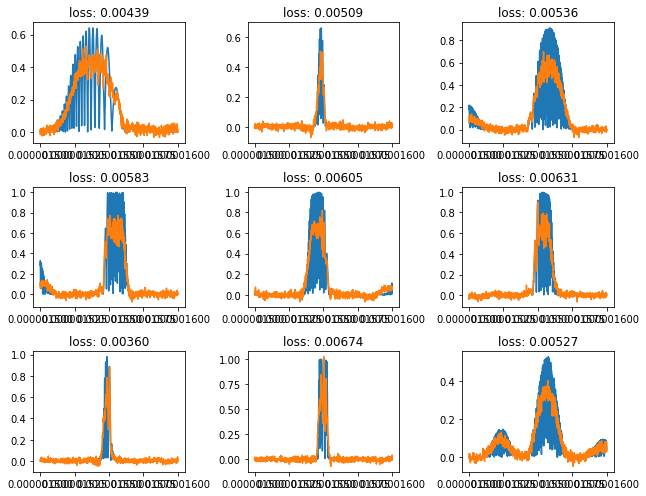

In [148]:
model.eval()
all_predictions = []
all_targets = []
all_loss = []
for i_batch, batch in enumerate(test_loader):
    predictions, targets = batch
    predictions = predictions.to(device)
    targets = targets.to(device)   
    with torch.no_grad():      
        predictions = model(predictions)
        loss = criterion(predictions, targets)
    all_loss.append(loss.item())
    all_predictions.append(predictions.cpu().numpy())
    all_targets.append(targets.cpu().numpy())

kd = 1
jd = 0
# for kd in range(1):
#     plt.plot(lambda_,all_targets[kd][jd])
#     plt.plot(lambda_,all_predictions[kd][jd])
# plt.figure(4)
# plt.plot(lambda_,all_targets[kd][jd])
# plt.plot(lambda_,all_predictions[kd][jd])
plt.figure(figsize=(40,20))
fig, subfigs = plt.subplots(3, 3, tight_layout=True)
for subfig,kd in zip(subfigs.reshape(-1),np.random.randint(0,len(test_loader),9)): 
        subfig.plot(lambda_,all_targets[kd][jd])
        subfig.plot(lambda_,all_predictions[kd][jd])
        subfig.set_title('loss: {:.5f}'.format(all_loss[kd]))


